In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
import multiprocessing as mp
import time
import glob
import re
import random
from sklearn.model_selection import train_test_split
import torch

sys.path.insert(0, '/Data/user/panhailin/git_lab/npspy')
import npspy as nps
from npspy import npsc

# 全局配置

In [2]:
torch.set_num_threads(10)

all_peps = ['hp1_1', 'hp1_2', 'hp1_3', 'hp1_4', 'hp1_5', 'hp1_6', 'hp1_7', 'hp1_8', 'hp1_9',
            'hp2_1', 'hp2_2', 'hp2_3', 'hp2_4', 'hp2_5', 'hp2_6',]
y_code_dict = nps.ml.set_y_codes_for_classes(np.array(all_peps)[:,None])
y_code_dict
y_to_label_dict = {v:k for k,v in y_code_dict.items()}
y_code_dict, y_to_label_dict

({np.str_('hp1_1'): 0,
  np.str_('hp1_2'): 1,
  np.str_('hp1_3'): 2,
  np.str_('hp1_4'): 3,
  np.str_('hp1_5'): 4,
  np.str_('hp1_6'): 5,
  np.str_('hp1_7'): 6,
  np.str_('hp1_8'): 7,
  np.str_('hp1_9'): 8,
  np.str_('hp2_1'): 9,
  np.str_('hp2_2'): 10,
  np.str_('hp2_3'): 11,
  np.str_('hp2_4'): 12,
  np.str_('hp2_5'): 13,
  np.str_('hp2_6'): 14},
 {0: np.str_('hp1_1'),
  1: np.str_('hp1_2'),
  2: np.str_('hp1_3'),
  3: np.str_('hp1_4'),
  4: np.str_('hp1_5'),
  5: np.str_('hp1_6'),
  6: np.str_('hp1_7'),
  7: np.str_('hp1_8'),
  8: np.str_('hp1_9'),
  9: np.str_('hp2_1'),
  10: np.str_('hp2_2'),
  11: np.str_('hp2_3'),
  12: np.str_('hp2_4'),
  13: np.str_('hp2_5'),
  14: np.str_('hp2_6')})

In [3]:
test_objs = [f"../../../00.data/{pep}_valid20.pkl" for pep in all_peps]
labels = all_peps

In [4]:
def stratified_sample(df, column_name, sample_size=15000, random_state=42):
    """
    对DataFrame按指定列类别分层随机抽样
    
    参数:
        df: 输入DataFrame
        column_name: 分层依据的列名
        sample_size: 每类抽取样本数(默认15000)
        random_state: 随机种子
    
    返回:
        抽样后的新DataFrame
    """
    re_df = df.groupby(column_name, group_keys=True).apply(
        lambda x: x.sample(min(len(x), sample_size), 
                          random_state=random_state),
        include_groups=False,
    )
    re_df[re_df.index.names[0]] =  [i[0] for i in re_df.index]
    re_df.index = [i[1] for i in re_df.index]
    return re_df

In [5]:
valid20_clean_rejected_pred_df = pd.read_csv('../../../04.tables/classification_for_real_data/hp12/valid20_clean_or_rejected.csv', index_col=0)
valid20_clean_rejected_pred_df = valid20_clean_rejected_pred_df[valid20_clean_rejected_pred_df['pred'] == 'clean']
tmp_objs = []
for pep, one_obj_file in zip(all_peps, test_objs):
    print(f'===={pep}====')
    one_obj = nps.io.read_pickle(one_obj_file)
    one_obj = nps.tl.extract_reads_as_an_obj(one_obj, np.intersect1d(valid20_clean_rejected_pred_df.index, list(one_obj.keys())))
    tmp_objs.append(one_obj)
    print(len(one_obj))
test_objs = tmp_objs

====hp1_1====
9676
====hp1_2====
27190
====hp1_3====
18485
====hp1_4====
12572
====hp1_5====
11227
====hp1_6====
13143
====hp1_7====
15638
====hp1_8====
6192
====hp1_9====
9378
====hp2_1====
27607
====hp2_2====
8718
====hp2_3====
17568
====hp2_4====
6148
====hp2_5====
10983
====hp2_6====
8172


# 读取pkl文件，生成readid，X，y组成的df

In [6]:
test_df = nps.ml.get_X_y_from_objs(objs=test_objs, labels=labels, y_code_dict=y_code_dict, down_sample_to=1000, att='signal')
test_df = stratified_sample(test_df, 'y', sample_size=6000, random_state=42)

# 通过data_df构建dataloader

In [7]:
batch_size = 64
test_dl = nps.ml.construct_dataloader_from_data_df(test_df, batch_size=batch_size, shuffle=False)

# predict

In [8]:
nps.ml.seed_everything(42)
clf = nps.ml.Trainer(lr=0.005, num_classes=len(all_peps), epochs=200, device='cuda', lr_scheduler_patience=3, label_smoothing=0.1, model_name='CNN1DL1000')

Model CNN1DL1000 has total parameter number: 6.21 M


In [9]:
pred_df = clf.predict(test_dl, name='clean_data', y_to_label_dict=y_to_label_dict)
pred_proba_df = clf.predict_proba(test_dl, name='clean_data',)
pred_proba_df.to_csv("../../../04.tables/classification_for_real_data/hp12/hp12_pred_proba.csv")
cm_df = nps.ml.get_cm(pred_df, label_order=all_peps)
cm_df.to_csv("../../../04.tables/classification_for_real_data/hp12/hp12_cm.csv")
print(cm_df)
print(np.sum(np.diag(cm_df))/len(pred_df))

 test_acc: 0.9485
 test_acc: 0.9485
pred   hp1_1  hp1_2  hp1_3  hp1_4  hp1_5  hp1_6  hp1_7  hp1_8  hp1_9  hp2_1  \
true                                                                          
hp1_1   5525     37     16      9     51      5      0      4      3      2   
hp1_2     77   5680     10      9     13     11      0      0     17      3   
hp1_3     23     11   5709      6     21     26      2     44     99      5   
hp1_4     25     20     15   5595     10     84      2     15     28     76   
hp1_5     41      5      8      1   5861      6      2      0      6      0   
hp1_6     10      2     41     60     21   5565      1     86    100     40   
hp1_7      5      7     13      3      7     11   5825      1      8      7   
hp1_8      8      0     39     20      2    119      0   5673    112      9   
hp1_9     11      9     91     12     10     75      3     81   5646      8   
hp2_1      6     20     13     78      0     37      4     13     14   5748   
hp2_2     10    

In [10]:
cm_df = pd.read_csv("../../../04.tables/classification_for_real_data/hp12/hp12_cm.csv", index_col=0)
cm_df.index.name = 'true'
cm_df.columns.name = 'pred'
cm_df

pred,hp1_1,hp1_2,hp1_3,hp1_4,hp1_5,hp1_6,hp1_7,hp1_8,hp1_9,hp2_1,hp2_2,hp2_3,hp2_4,hp2_5,hp2_6
true,,,,,,,,,,,,,,,
hp1_1,5525,37,16,9,51,5,0,4,3,2,10,15,12,2,309
hp1_2,77,5680,10,9,13,11,0,0,17,3,0,1,4,2,173
hp1_3,23,11,5709,6,21,26,2,44,99,5,3,10,11,12,18
hp1_4,25,20,15,5595,10,84,2,15,28,76,8,6,7,7,102
hp1_5,41,5,8,1,5861,6,2,0,6,0,2,5,46,3,14
hp1_6,10,2,41,60,21,5565,1,86,100,40,8,12,16,20,18
hp1_7,5,7,13,3,7,11,5825,1,8,7,19,68,13,8,5
hp1_8,8,0,39,20,2,119,0,5673,112,9,2,0,0,4,12
hp1_9,11,9,91,12,10,75,3,81,5646,8,6,7,4,20,17


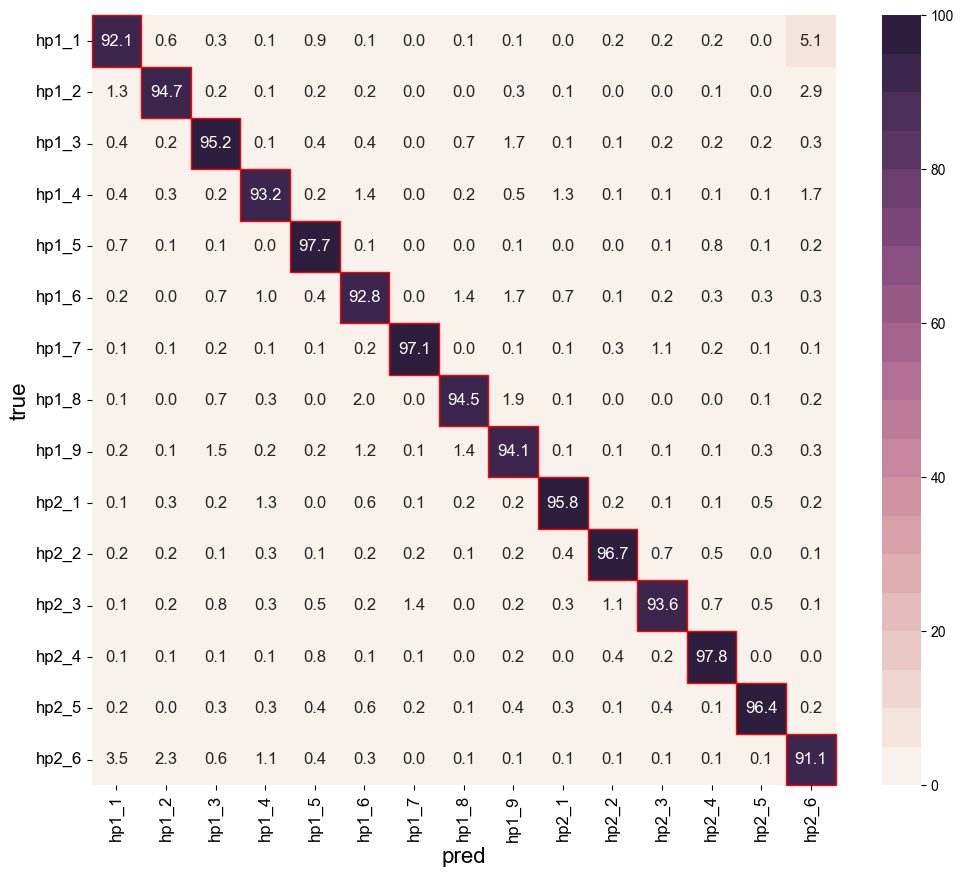

In [11]:
plt.rcParams['axes.labelsize'] = 16
nps.ml.plot_cm(cm_df, figsize=(12,10), nor_to_percent_for_each_pred=True, annot_size=12.0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('../../../05.figures/classification_for_real_data/hp12/cm.pdf', bbox_inches='tight')